# Convolution and CNN demo

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [ ]:
using PyCall, PyPlot
#= run once
using Pkg
Pkg.add("Colors")
Pkg.add("ImageTransformations")
=#
using ImageTransformations
using Colors
using FileIO
using Images
SciPySignal = pyimport("scipy.signal") # import convolve2d

 Resolving package versions...


  likely near C:\Users\Rex Chau\.julia\packages\IJulia\cwvsj\src\kernel.jl:52


 Installed DSP ─ v0.5.2
  Updating `C:\Users\Rex Chau\.julia\environments\v0.7\Project.toml`
  [717857b8] + DSP v0.5.2
  Updating `C:\Users\Rex Chau\.julia\environments\v0.7\Manifest.toml`
  [717857b8] + DSP v0.5.2


┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1187


In [65]:
function preprocess_image(filename)
    img = load(filename) # read in the image
    img = imresize(img, ratio=1) # resize it if you want
    # above: the mode='constant' is just to avoid a warning, I don't expect the original
    # image to be smaller than 100x100
    return convert(Array{Gray{Normed{UInt8,8}},2},img) # make it grayscale
    return img
end
function img2Array(img;channels=1)
    n, d = size(img)
    return convert(Array{Float64},[getfield(img[i,j],k) for i in 1:n,j in 1:d,k in 1:channels])
end
function array2Img(img;color=Gray)
    return colorview(color,img)
end
function show_conv(img, filt)

    plt.figure(figsize=(8,16))
    plt.subplot(1,2,1)
    
    plt.imshow(img, cmap="gray")
    plt.xticks(())
    plt.yticks(())
    plt.title("original")
    I_filt = SciPySignal.convolve2d(img,filt, boundary="symm", mode="same")

    plt.subplot(1,2,2)
    if sum(filt) == 0 # a trick to make the images easier to see, not part of the "math"
        I_filt = broadcast(abs,I_filt)./maximum(broadcast(abs,I_filt))
    end

    I_filt = broadcast(x->max(0,x), I_filt) # set negative values to 0, for visualization purposes
    I_filt = broadcast(x->min(1,x), I_filt) # set values greater than 1 to 1, for visualization purposes

    plt.imshow(I_filt, cmap="gray")

    plt.xticks(())
    plt.yticks(())
    plt.title("filtered")

    return I_filt
end

show_conv (generic function with 1 method)

## Some examples of convolutions with an image of bricks

#### original image

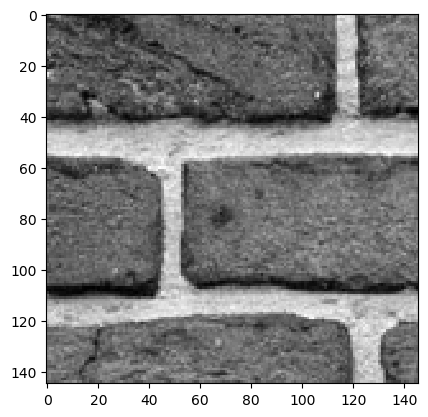

In [60]:
img = reshape(img2Array(preprocess_image("img/bricks_smaller.jpg")),145,146)
plt.imshow(img,cmap="gray");

#### horizontal blurring

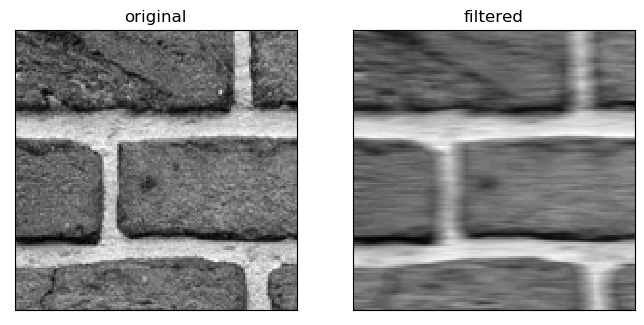

(1, 10)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [68]:
ft1 = 0.1.*reshape(ones(10),1,10)
println(size(ft1))
println(ft1)

res2 = show_conv(img, ft1);

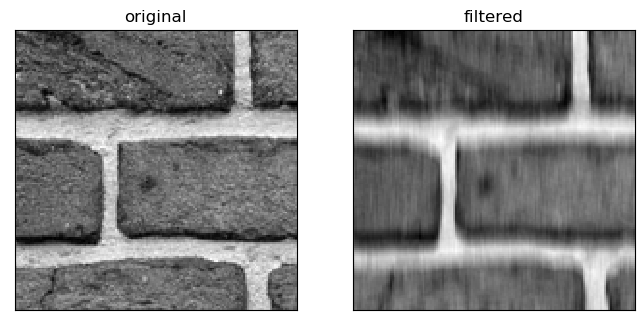

(10, 1)
[0.1; 0.1; 0.1; 0.1; 0.1; 0.1; 0.1; 0.1; 0.1; 0.1]


In [70]:
ft2 = ft1'
println(size(ft2))
println(ft2)
res2 = show_conv(img, ft2);

#### blurring in both directions

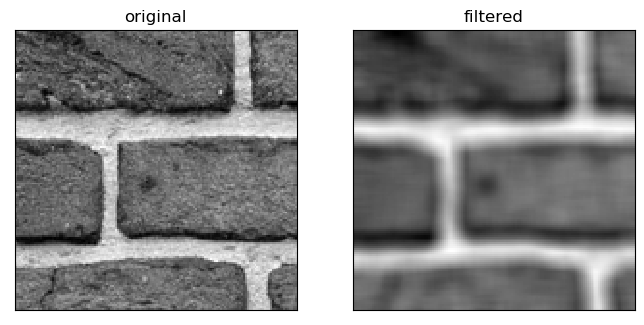

(10, 10)


In [76]:
ft5 = 0.01.*ones(10,10)
println(size(ft5))
res5 = show_conv(img, ft5);#### Horizontal derivatives

#### Horizontal derivatives

(3, 1)


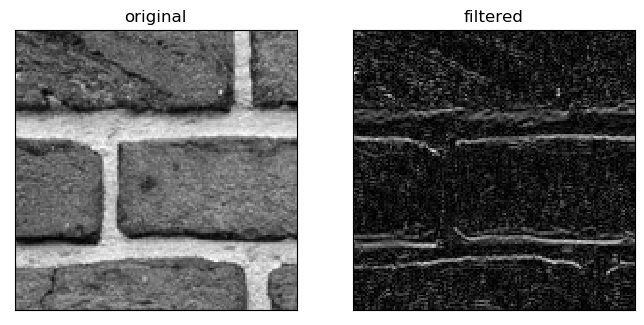

[-1; 0; 1]


In [78]:
ft3 = reshape([-1, 0, 1],3,1)
println(size(ft3))
println(ft3)
res3 = show_conv(img, ft3);

#### Vertical derivatives

(1, 3)


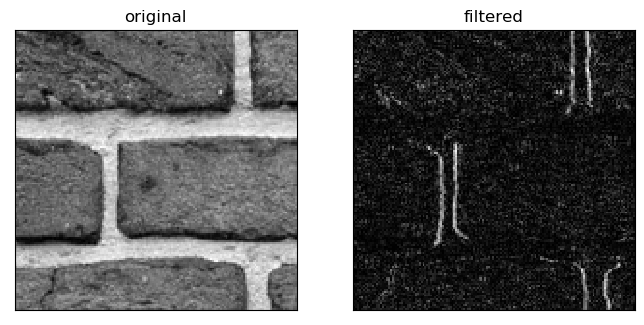

[-1 0 1]


In [79]:
ft4 = ft3'
println(size(ft4))
println(ft4)
res4 = show_conv(img, ft4);

#### Sum of vertical and horizontal derivatives

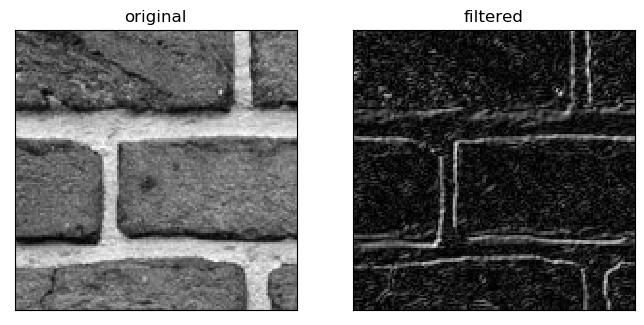

(3, 3)
[-2 -1 0; -1 0 1; 0 1 2]


In [81]:
ft6 = repeat(ft3,1,3)+repeat(ft4,3,1)#### Increased intensity
println(size(ft6))
println(ft6)
res6 = show_conv(img, ft6);

#### Increased intensity

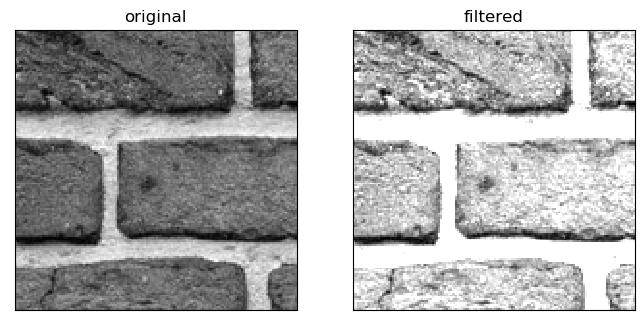

(1, 1)
[2.0]


In [82]:
ft7 = ones(1,1).*2
println(size(ft7))
println(ft7)
res6 = show_conv(img, ft7);

## Convolutions as matrix multiplication (bonus)

Create an example signal:

In [2]:
x = rand(0:10,10)
x = [4,3,1,6,0,3,6,7,7,1]

10-element Array{Int64,1}:
 4
 3
 1
 6
 0
 3
 6
 7
 7
 1

Convolve it with an averaging filter of width 5....

In [3]:
include("__init__.jl")
w = ones(5)./5

conv(x,w,mode="valid")

6-element Array{Float64,1}:
 2.8000000000000003
 2.6               
 3.2               
 4.4               
 4.6000000000000005
 4.800000000000001 

Create the matrix version

In [342]:
SciPyLinalg = pyimport("scipy.linalg")
W = SciPyLinalg.toeplitz([1/5,0,0,0,0,0],[1/5,1/5,1/5,1/5,1/5,0,0,0,0,0])
W

6×10 Array{Float64,2}:
 0.2  0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0
 0.0  0.2  0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0
 0.0  0.0  0.2  0.2  0.2  0.2  0.2  0.0  0.0  0.0
 0.0  0.0  0.0  0.2  0.2  0.2  0.2  0.2  0.0  0.0
 0.0  0.0  0.0  0.0  0.2  0.2  0.2  0.2  0.2  0.0
 0.0  0.0  0.0  0.0  0.0  0.2  0.2  0.2  0.2  0.2

See that the result is the same as the convolution

In [349]:
W*x

6-element Array{Float64,1}:
 2.8000000000000003
 2.6               
 3.2               
 4.4               
 4.6000000000000005
 4.800000000000001 

If you care about boundary conditions, here's another one that returns an output that's the same size as the input:

In [6]:
conv(x,w,mode="same")

14-element Array{Float64,1}:
 0.8               
 1.4000000000000001
 1.6               
 2.8000000000000003
 2.8000000000000003
 2.6               
 3.2               
 4.4               
 4.6000000000000005
 4.800000000000001 
 4.200000000000001 
 3.0000000000000004
 1.6               
 0.2               

In [399]:
Wsame = vcat([0.2 0.2 0.2 0 0 0 0 0 0 0],[0.2 0.2 0.2 0.2 0 0 0 0 0 0],W,[0 0 0 0 0 0 0.2 0.2 0.2 0.2],[0 0 0 0 0 0 0 0.2 0.2 0.2])
Wsame

10×10 Array{Float64,2}:
 0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0  0.0
 0.2  0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0
 0.0  0.2  0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0
 0.0  0.0  0.2  0.2  0.2  0.2  0.2  0.0  0.0  0.0
 0.0  0.0  0.0  0.2  0.2  0.2  0.2  0.2  0.0  0.0
 0.0  0.0  0.0  0.0  0.2  0.2  0.2  0.2  0.2  0.0
 0.0  0.0  0.0  0.0  0.0  0.2  0.2  0.2  0.2  0.2
 0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2  0.2  0.2
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2  0.2

In [429]:
@time conv(x,w,mode="same")
@time Wsame*x

  0.000013 seconds (6 allocations: 480 bytes)
  0.000015 seconds (27 allocations: 2.781 KiB)


10-element Array{Float64,1}:
 1.6               
 2.8000000000000003
 2.8000000000000003
 2.6               
 3.2               
 4.4               
 4.6000000000000005
 4.800000000000001 
 4.200000000000001 
 3.0000000000000004